<a href="https://colab.research.google.com/github/wikipathways/BioThings_Explorer_PFOCR_prioritization/blob/main/PET_notebook_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PET Notebook

### A notebook for exploring Pathway Enriched TRAPI results

For interactive exploration of TRAPI results using the PFOCR pathway figure database to help interpret results by the enrichment of nodes (CURIEs) representing genes, proteins, drugs, metabolites, and diseases.

Run the entire notebook to process an example TRAPI response. Paste your own result URL into the User Inputs form below and re-run all cells below it. Then scroll down to the Overview of Pathway Figure Results section to explore your own results.

Features:
 * Toggle code view - this button will hide all code chunks (might not work in Google Colab, which has its own chunk hiding features)
 * Maximum number of pathway results - default is 15. Reduce this by slider or by typing to focus on fewer results.
 * Require specified query nodes in pathway results - default is True. Deselect if there are too few pathway results or if you really don't particularly care about the nodes specified in your query.

## Setup

Installation of required packages. 

In [1]:
!pip install numpy pandas requests requests_cache SetSimilaritySearch fisher > pip-log.txt

In [1]:
from IPython.display import display, HTML
display(HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code view"></form>
'''))
#load packages
from urllib.request import urlopen
import requests
import json
import numpy as np
from copy import copy,deepcopy
import pandas as pd
from fisher import pvalue_npy
from scipy.stats import fisher_exact
# Importing reduce for rolling computations
from functools import reduce
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import Button

## User Inputs

Please complete the form below.

In [2]:
# TRAPI Result URL
trapi_results_url = widgets.Text(
    value='https://arax.ncats.io/api/arax/v1.3/response/7b14f961-9066-41f7-9e3b-d76b2b4a7fac',
    placeholder='Paste here',
    description='',
    disabled=False
)

# Max number of pathway results desired
num_pathways = widgets.IntSlider(
    value=15,
    min=1,
    max=15,
    step=1,
    description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Whether to require figure results include user-specified node IDs from the query
# If true then atleast one of the specified query node ids must be in the result figures
# If false then figures without any of these node ids are also included
require_specified_query_nodes = widgets.Checkbox(
    value=True,
    description='',
    disabled=False,
    indent=False
)
require_specified_query_nodes

#define the button
button = Button(description='Run all cells below')
from IPython.display import display, Javascript

def run_all_cells_below(b):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
button.on_click(run_all_cells_below)

box_items = [widgets.VBox([widgets.HBox([widgets.Label('TRAPI Result URL:'),trapi_results_url]),
                        widgets.HBox([widgets.Label('Maxiumum number of desired pathway results:'),num_pathways]),
                        widgets.HBox([widgets.Label('Require specified query nodes in pathway results:'),require_specified_query_nodes])]),
            button]
widgets.Box(box_items, layout=widgets.Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='62%'
))

Box(children=(VBox(children=(HBox(children=(Label(value='TRAPI Result URL:'), Text(value='https://arax.ncats.i…

<IPython.core.display.Javascript object>

## Load TRAPI Results

Retrieve the JSON response from the provided URL.

In [3]:
with urlopen(trapi_results_url.value) as url:
    trapi_results_json = json.load(url)

# get the TRAPI results and knowledge graph from the json response
trapi_message = trapi_results_json['message']
trapi_query = trapi_message["query_graph"]
trapi_results = trapi_message["results"]
trapi_results_df = pd.json_normalize(trapi_results)

# prepare results as a human-readable dataframe
for c in list(trapi_results_df.columns):
    if isinstance(trapi_results_df[c][0], list):
        trapi_results_df[c] = trapi_results_df[c].str[0].str['id']
        
print('Summary: query_graph:',
      len(trapi_query['edges'].items()),'edges,',
      len(trapi_query['nodes'].items()),'nodes; results:',
      len(trapi_results) )
#display(trapi_results_df)

Summary: query_graph: 2 edges, 3 nodes; results: 7


## Normalize TRAPI Result Dataframe for Enrichment Analysis
  
Unify node identifiers to sources supported by PFOCR pathway figures (NCBIGene, MESH) and prepare CURIE sets for enrichment analysis.

In [4]:
# Using the xrefs in knowledge_graph node attributes we are building dictionaries of 
# result CURIEs and names.
preferred_prefixes = set(["NCBIGene", "MESH"])
curie_to_name = dict()
curie_to_unified_curies = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    #first check if k is already what we want
    [prefix, identifier] = k.split(":")
    if prefix in preferred_prefixes:
        curie_to_unified_curies[k] = k
    #else dig into attributes to collect one or more relevant mappings
    else:            
        for a in v["attributes"]:
            if a["attribute_type_id"] == "biolink:xref":
                curies = a["value"]
                unified_curies = set()
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curies.add(curie)
                #assess collected curies
                if len(unified_curies) == 1:
                    curie_to_unified_curies[k] = list(unified_curies)[0]
                elif len(unified_curies) > 1:
                    curie_to_unified_curies[k] = unified_curies
    #get the node name
    if "name" in v:
        curie_to_name[k] = v["name"]
    elif k in curie_to_unified_curies.keys():
        curie_to_name[k] = curie_to_unified_curies[k]
    else:
        curie_to_name[k] = "NaN"
                    
# Append new columns to results df: name and unified_curie
columns_to_lookup = [col for col in trapi_results_df.columns if col.startswith("node_bindings") and col[-2].lower() == 'n'  and col[-1].isdigit()]
new_name_columns = [col.replace("bindings","name") for col in columns_to_lookup]
new_unified_curies_columns = [col.replace("bindings","unified_curies") for col in columns_to_lookup]

# Simple lookup function
def lookup(row, col, lookup_dict):
    return lookup_dict.get(row[col], 'NA')

# Add the new columns per node by applying the lookup function
for i in range(len(columns_to_lookup)):
    trapi_results_df[new_name_columns[i]] = trapi_results_df.apply(lambda row: lookup(row, columns_to_lookup[i], curie_to_name), axis=1)
    trapi_results_df[new_unified_curies_columns[i]] = trapi_results_df.apply(lambda row: lookup(row, columns_to_lookup[i], curie_to_unified_curies), axis=1)

# Append a new columns: result_name and unified_curie_set for pathway analysis
#trapi_results_df['result_name'] = trapi_results_df[new_name_columns[0]].str.cat(trapi_results_df[new_name_columns], sep="_")
trapi_results_df['result_name'] = trapi_results_df.reset_index().index.astype(str)
trapi_results_df['result_name'] = trapi_results_df['result_name'].str.cat(trapi_results_df[new_name_columns], sep='_')


def collect_curie_set(row):
    unified_curie_set = set()
    for c in new_unified_curies_columns:
        if isinstance(row[c], set):
            unified_curie_set.update(row[c])
        else:
            unified_curie_set.add(row[c])
    return unified_curie_set
trapi_results_df['unified_curie_set'] = trapi_results_df.apply(collect_curie_set, axis=1)
display_columns = ['normalized_score','reasoner_id','score']
display_columns.extend(new_name_columns)
display(trapi_results_df[display_columns])

,normalized_score,reasoner_id,score,node_name.n0,node_name.n1,node_name.n2
0,100.000000,BTE,2.906806,Imatinib mesylate,VEGFA,Asthma
1,85.714286,BTE,1.120319,Imatinib mesylate,CASP8,Asthma
2,71.428571,BTE,0.851030,Imatinib mesylate,LYN,Asthma
3,57.142857,BTE,0.796666,Imatinib mesylate,CXCL8,Asthma
4,28.571429,BTE,0.000000,Imatinib mesylate,PARP1,Asthma
5,28.571429,BTE,0.000000,Imatinib mesylate,PDGFRA,Asthma
6,28.571429,BTE,0.000000,Imatinib mesylate,JUN,Asthma


## Collect CURIEs specified in query

Prepare a set of unified CURIEs from the specified query nodes. This set will be used to restrict or prioritize enrichment results based on the user parameter: `require_specified_query_nodes`.

In [5]:
#get all nodes with ids from the query 
user_specified_ids = set()
for k, v in trapi_query['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        n = trapi_results[0]['node_bindings'][k][0]['id']
        c = curie_to_unified_curies.get(n)
        if isinstance(c, set):
            user_specified_ids.update(c)
        else:
            user_specified_ids.add(c)
print(user_specified_ids)        

set()


## Load PFOCR Pathway Figure Database

Load pathway figure content and metadata for enrichment analysis.

In [6]:
# read in figure metadata for all PFOCR figures
figure_metadata_df = pd.read_csv('https://www.dropbox.com/s/9jorbzpq2k8n5tr/figures_metadata.csv?dl=1', index_col=0)

# read in figure CURIEs for all PFOCR figures
figure_curie_df = pd.read_csv('https://www.dropbox.com/s/y3ks74obs3nrjjz/figures_curie.csv?dl=1')

In [7]:
# Define total sets of unified curies for enrichment test
total_pfocr_pathways = len(figure_metadata_df.index)
print("Total number of PFOCR pathways: ", total_pfocr_pathways)
total_pfocr_curies = set(figure_curie_df['curie'])
print("Total number of PFOCR pathway CURIEs: ", len(total_pfocr_curies))
total_result_curies = set([item for sub_set in trapi_results_df['unified_curie_set'] for item in sub_set])
total_result_curies_possible = total_result_curies.intersection(total_pfocr_curies) #only consider possible matches
print("Total number of TRAPI result CURIEs: ", len(total_result_curies_possible))

Total number of PFOCR pathways:  77719
Total number of PFOCR pathway CURIEs:  30163
Total number of TRAPI result CURIEs:  8


## Iterative Enrichment of TRAPI Results Using PFOCR Pathway Figures

We identify the top PFOCR figures by iteratively running Fisher's Exact Test to identify PFOCR pathway figures that are most similar to all the CURIEs from the TRAPI results. To get each figure, we do the following:

1. Run Fisher's Exact Test for the CURIEs from each figure vs. the set of the unique CURIEs found from all the TRAPI results, limiting each set of CURIEs to those found in any PFOCR pathway figure
2. Select the pathway figure with the lowest p-value
3. Exclude that pathway figure and the CURIEs in it
4. Repeat to get the next pathway figure, continuing until:
    - we run out of enrichement results
    - we repeated steps 1-3 the desired number of times (user input: ```num_pathways```)

In [8]:
# Definition the parameters with example values for enrichment test
# M = 30163  # Total number of curies in PFOCR pathway figure database
# N = 571   # Total number of curies in TRAPI result set
# x = 10   # Number of curies in the TRAPI result set that belong to a particular pathway
# k = 24   # Number of curies in a particular pathway 

#reset the set of required CURIES
required_curies = set()

def set_union(series):
    return reduce(lambda x, y: x | y, series)

def create_set(series):
    return set(series.tolist())

def get_results_by_curies(curie_set):
    subset_df = trapi_results_df[trapi_results_df['unified_curie_set'].apply(lambda x: len(x.intersection(curie_set)) > 0)]
    return set(subset_df['result_name'].tolist())

pathway_figure_data = []
def get_next_pathway_figures(
    possible_matched_pfocr_curie_count,
    remaining_figures_df,
    remaining_trapi_curie_count,
    required_curies,
    iteration_limit=num_pathways.value, #this is the user-defined parameter for the number of figures
    i=0,
    pathway_figure_ids=[],
):
    remaining_figure_count = len(
        remaining_figures_df
    )

    if (
        i >= iteration_limit
    ) or (
        len(remaining_trapi_curie_count) == 0
    ) or (
        remaining_figure_count == 0
    ):
        return pathway_figure_ids
    
    remaining_figures_df["figure_curie_count"] = remaining_figures_df["curie_set"].map(len)

    remaining_figures_df["figure_curies_in_trapi_results"] = remaining_figures_df["curie_set"].map(
        lambda curie_set: remaining_trapi_curie_count.intersection(
            set(curie_set)
        )
    )

    # number of CURIEs in both TRAPI results and figure = x
    remaining_figures_df["yes_trapi_results_yes_figure"] = remaining_figures_df[
        "figure_curies_in_trapi_results"
    ].map(len)

    # number of CURIEs in TRAPI results but not in figure = N-x
    remaining_figures_df["yes_trapi_results_no_figure"] = (
        len(remaining_trapi_curie_count) -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results but in figure = k-x
    remaining_figures_df["no_trapi_results_yes_figure"] = (
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results and not in figure = M-k-(N-x)
    # ie., number of unique CURIEs only in other figures
    remaining_figures_df["no_trapi_results_no_figure"] = (
        possible_matched_pfocr_curie_count -
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_no_figure"]
    )

    # Vectorized fisher_exact test, see https://stackoverflow.com/a/58661068/5354298
    # Contingency table values (in arg order): x, N-x, k-x, M-k-(N-x) 
    _, _, twosided = pvalue_npy(
        remaining_figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
    )

    remaining_figures_df["p_value"] = pd.Series(twosided, index=remaining_figures_df.index)
    remaining_figures_df["p_value"].sort_values()
    
    # In case of a p_value tie, we sort by yes_trapi_results_yes_figure count and keep the top single hit
    min_df = remaining_figures_df[
        remaining_figures_df["p_value"] == remaining_figures_df["p_value"].min()
    ]
    min_df = min_df.sort_values(by='yes_trapi_results_yes_figure', ascending=False).head(1)
    
    if required_curies:
        # TODO: it might make sense to keep prioritizing the required CURIEs, but
        #       it's not clear whether this is always what we want.
        #       In some cases, we could obscure a different set of results that may
        #       be valuable but not because of the overlap with the required CURIEs.
        curies_to_exclude = set(
            min_df["figure_curies_in_trapi_results"].agg(set_union)
        ) - required_curies
    else:
        curies_to_exclude = set(min_df["figure_curies_in_trapi_results"].agg(set_union))
        
    if len(curies_to_exclude - required_curies) == 0:
        # On this iteration, we failed to match any new CURIE(s), other than
        # possibly just the required CURIEs.
        return pathway_figure_ids
        
    new_pathway_figure_ids = min_df.index.tolist()
    pathway_figure_ids.extend(new_pathway_figure_ids)
    
    for pathway_figure_id, min_row in min_df.iterrows():
        pathway_figure_data.append({
            "iteration": i,
            "figure_id": pathway_figure_id,
            "p_value": min_row["p_value"],
            "fraction_of_trapi_curies_in_figure" : min_row["yes_trapi_results_yes_figure"]/len(total_result_curies_possible),
            "fraction_of_figure_curies_in_trapi_results" : min_row["yes_trapi_results_yes_figure"]/(min_row["yes_trapi_results_yes_figure"] + min_row["no_trapi_results_yes_figure"]),
            "yes_trapi_results_yes_figure": min_row["yes_trapi_results_yes_figure"],
            "yes_trapi_results_no_figure": min_row["yes_trapi_results_no_figure"],
            "no_trapi_results_yes_figure": min_row["no_trapi_results_yes_figure"],
            "no_trapi_results_no_figure": min_row["no_trapi_results_no_figure"],
            "figure_curies_in_trapi_results": min_row["figure_curies_in_trapi_results"],
            "trapi_result_set": get_results_by_curies(curies_to_exclude),
            "trapi_result_count": 0,
            "curie_set": min_row["curie_set"],
            "curies_to_exclude": curies_to_exclude,
            "len_curies_to_exclude": len(curies_to_exclude),
            "remaining_figure_count": remaining_figure_count,
            "remaining_trapi_curie_count": len(remaining_trapi_curie_count),
            "pathway_figure_id_count": len(pathway_figure_ids),
        })
    
    # for next iteration, exclude figures we've already added to cluster figures
    next_remaining_figures_df = remaining_figures_df[
        (~remaining_figures_df.index.isin(
            pathway_figure_ids
        ))
    ]
    
    #print(f'iteration {i:>2}: figures: {len(new_pathway_figure_ids):>2}, CURIEs: {len(curies_to_exclude):>2}')
    
    return get_next_pathway_figures(
        possible_matched_pfocr_curie_count,
        next_remaining_figures_df.reset_index().set_index("figure_id"),
        remaining_trapi_curie_count - curies_to_exclude,
        required_curies,
        iteration_limit,
        i + 1,
        pathway_figure_ids,
    )

possible_matched_figure_curie_df = figure_curie_df[figure_curie_df["curie"].isin(
    list(total_pfocr_curies)
)]
possible_matched_pfocr_curie_count = len(set(
    possible_matched_figure_curie_df["curie"].drop_duplicates()
))
#print(f'possible_matched_pfocr_curie_count: {possible_matched_pfocr_curie_count}')

possible_matched_figures_df = possible_matched_figure_curie_df[
    ["figure_id", "curie"]
].groupby("figure_id").agg(
    create_set
).rename(columns={
    "curie": "curie_set"
})

possible_matched_figures_df["figure_curies_in_trapi_results_count"] = possible_matched_figures_df[
    "curie_set"
].map(
    lambda curie_set: len(total_result_curies_possible.intersection(
        set(curie_set)
    ))
)

overlapping_possible_matched_figures_df = possible_matched_figures_df[
    possible_matched_figures_df["figure_curies_in_trapi_results_count"] > 0
]

# Require that figures have user-specified CURIEs from the query
if require_specified_query_nodes.value:
    required_curies = user_specified_ids
if required_curies:
    overlapping_possible_matched_figures_df = overlapping_possible_matched_figures_df[
        overlapping_possible_matched_figures_df["curie_set"].map(
            # require all of them
            # lambda curie_set: len(curie_set.intersection(required_curies)) == len(required_curies)
            # require at least one of them
            lambda curie_set: len(curie_set.intersection(required_curies)) > 0
        )
    ]

pathway_figure_ids_out = get_next_pathway_figures(
    possible_matched_pfocr_curie_count,
    overlapping_possible_matched_figures_df.reset_index().set_index("figure_id"),
    total_result_curies_possible,
    required_curies,
)
#print(f'pathway figure count: {len(pathway_figure_ids_out)}')
pathway_figure_df = pd.DataFrame.from_records(pathway_figure_data)
pathway_figure_df['trapi_result_count'] = pathway_figure_df['trapi_result_set'].apply(lambda x: len(x))
#display(pathway_figure_df)

In [9]:
display(pathway_figure_df)

,iteration,figure_id,p_value,fraction_of_trapi_curies_in_figure,fraction_of_figure_curies_in_trapi_results,yes_trapi_results_yes_figure,yes_trapi_results_no_figure,no_trapi_results_yes_figure,no_trapi_results_no_figure,figure_curies_in_trapi_results,trapi_result_set,trapi_result_count,curie_set,curies_to_exclude,len_curies_to_exclude,remaining_figure_count,remaining_trapi_curie_count,pathway_figure_id_count
0,0,PMC3929246__bctt-5-043Fig1.jpg,7.260098e-09,0.500,0.040816,4,4,94,30061,"{NCBIGene:3576, NCBIGene:3725, NCBIGene:841, N...","{1_Imatinib mesylate_CASP8_Asthma, 4_Imatinib ...",4,"{NCBIGene:25976, NCBIGene:841, NCBIGene:83666,...","{NCBIGene:3576, NCBIGene:3725, NCBIGene:841, N...",4,9466,8,1
1,1,PMC5919962__fonc-08-00107-g001.jpg,8.621233e-08,0.375,0.035294,3,1,82,30077,"{NCBIGene:4067, NCBIGene:7422, NCBIGene:5156}","{2_Imatinib mesylate_LYN_Asthma, 5_Imatinib me...",3,"{NCBIGene:5139, NCBIGene:5155, NCBIGene:10284,...","{NCBIGene:4067, NCBIGene:7422, NCBIGene:5156}",3,9465,4,2
2,2,PMC7023894__nihms-1556086-f0004.jpg,4.309916e-04,0.125,0.076923,1,0,12,30150,{MESH:D001249},"{6_Imatinib mesylate_JUN_Asthma, 4_Imatinib me...",7,"{MESH:C060706, MESH:D001249, NCBIGene:23209, N...",{MESH:D001249},1,9464,1,3


# Overview of Pathway Figure Results

The figures and tables below summarize the intersections and groupings of your TRAPI results with published pathway figures from the PFOCR daatbase.

### TRAPI results grouped by pathway figures

Each pathway figure in order of significance with metadata and a table of the TRAPI results containing pathway-intersecting CURIEs (beyond the "required" CURIEs). Click 'o' to toggle between 3 output modes.

In [10]:
from IPython.display import display, Image
from IPython.core.display import HTML 

print('Total number of pathway figure results:', len(pathway_figure_df.index))

for index, row in pathway_figure_df.iterrows():
    figid = row['figure_id']
    fpmc,fname = figid.split("__")
    furl = "https://www.ncbi.nlm.nih.gov/pmc/articles/"+fpmc+"/bin/"+fname
    pfocrurl = "https://pfocr.wikipathways.org/figures/"+figid.replace(".jpg",".html")
    fdf = trapi_results_df[trapi_results_df['result_name'].isin(row['trapi_result_set'])]
    
    #time to display
    display(HTML('<hr>'))
    display(Image(url=furl))
    display(HTML('<h3>'+str(index+1)+'.&nbsp;'+figure_metadata_df.loc[figid]['figure_title']+'</h3>'+
                 '&nbsp;&nbsp;&nbsp;&nbsp; * <a href="'+pfocrurl+'" target="_blank">Link to pathway figure at PFOCR</a>'+
                 ' * <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/'+fpmc+'" target="_blank">Link to article at PMC</a>'))
    print('Number of TRAPI results represented by this pathway:',len(row['trapi_result_set']))
    print('Number of CURIEs represented by this pathway:',
          len(row['figure_curies_in_trapi_results']))
    print('Query-specified CURIEs in this pathway:',
          row['curie_set'].intersection(user_specified_ids))
    display(fdf[display_columns])

Total number of pathway figure results: 3


Number of TRAPI results represented by this pathway: 4
Number of CURIEs represented by this pathway: 4
Query-specified CURIEs in this pathway: set()


,normalized_score,reasoner_id,score,node_name.n0,node_name.n1,node_name.n2
1,85.714286,BTE,1.120319,Imatinib mesylate,CASP8,Asthma
3,57.142857,BTE,0.796666,Imatinib mesylate,CXCL8,Asthma
4,28.571429,BTE,0.000000,Imatinib mesylate,PARP1,Asthma
6,28.571429,BTE,0.000000,Imatinib mesylate,JUN,Asthma


Number of TRAPI results represented by this pathway: 3
Number of CURIEs represented by this pathway: 3
Query-specified CURIEs in this pathway: set()


,normalized_score,reasoner_id,score,node_name.n0,node_name.n1,node_name.n2
0,100.000000,BTE,2.906806,Imatinib mesylate,VEGFA,Asthma
2,71.428571,BTE,0.851030,Imatinib mesylate,LYN,Asthma
5,28.571429,BTE,0.000000,Imatinib mesylate,PDGFRA,Asthma


Number of TRAPI results represented by this pathway: 7
Number of CURIEs represented by this pathway: 1
Query-specified CURIEs in this pathway: set()


,normalized_score,reasoner_id,score,node_name.n0,node_name.n1,node_name.n2
0,100.000000,BTE,2.906806,Imatinib mesylate,VEGFA,Asthma
1,85.714286,BTE,1.120319,Imatinib mesylate,CASP8,Asthma
2,71.428571,BTE,0.851030,Imatinib mesylate,LYN,Asthma
3,57.142857,BTE,0.796666,Imatinib mesylate,CXCL8,Asthma
4,28.571429,BTE,0.000000,Imatinib mesylate,PARP1,Asthma
5,28.571429,BTE,0.000000,Imatinib mesylate,PDGFRA,Asthma
6,28.571429,BTE,0.000000,Imatinib mesylate,JUN,Asthma


### Matrix of TRAPI results by pathway figures

A binary heatmap: rows are TRAPI result names sorted by original result number (e.g., 0-7), and columns are pathway figures sorted by significance (i.e., iteration order). Note: the query-specified nodes are excluded from the overlap logic, otherwise all results would overlap with all pathway figures.

In [11]:
#as heatmap, sorting rows by pathway figure groupings
pathway_figure_df_tall = pathway_figure_df[["figure_id","trapi_result_set"]].explode("trapi_result_set")
rep_trapi_result_count = len(pathway_figure_df_tall['trapi_result_set'].unique())
pathway_figure_df_tall = pathway_figure_df_tall.rename(columns={"trapi_result_set": "TRAPI results"})
pathway_figure_df_tall
pathway_figure_df_tall["value"]=1
df=pd.pivot_table(pathway_figure_df_tall, values="value", index=["TRAPI results"], columns="figure_id", fill_value=0)
df=df[pathway_figure_df['figure_id']]
df=df.sort_values(by=list(df.columns))
print('Total number of TRAPI results represented by pathways:', rep_trapi_result_count, 'out of', len(trapi_results_df.index))

Total number of TRAPI results represented by pathways: 7 out of 7


Pathway figures by TRAPI results, sorting rows by pathway figure groupings  (not all 7 row names are shown)


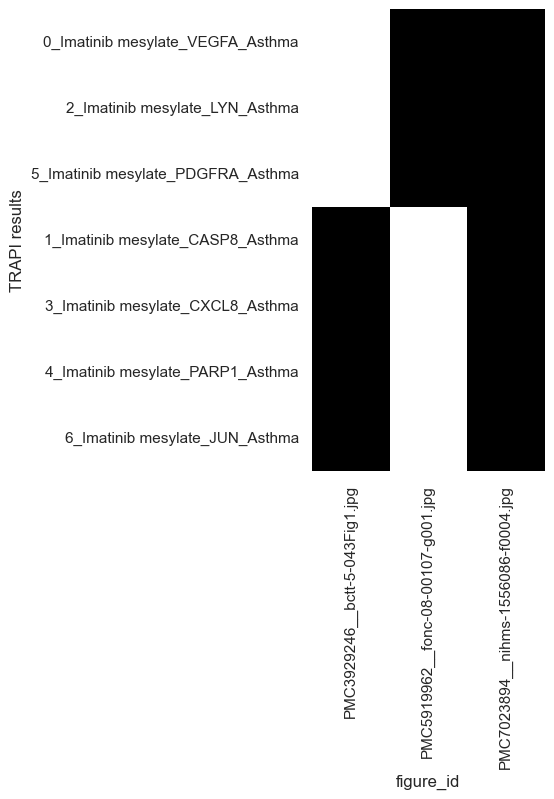

In [12]:
plt_w = len(pathway_figure_df.index)
plt_h = min(rep_trapi_result_count,plt_w*2)
plt.figure(figsize = (plt_w,plt_h))
sns.set()
sns.heatmap(df, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
if(plt_h ==rep_trapi_result_count):
    print('Pathway figures by TRAPI results, sorting rows by pathway figure groupings')
else:
    print('Pathway figures by TRAPI results, sorting rows by pathway figure groupings  (not all',rep_trapi_result_count,'row names are shown)')
plt.show()

Pathway figures by TRAPI results, sorting rows by result order  (not all 7 row names are shown)


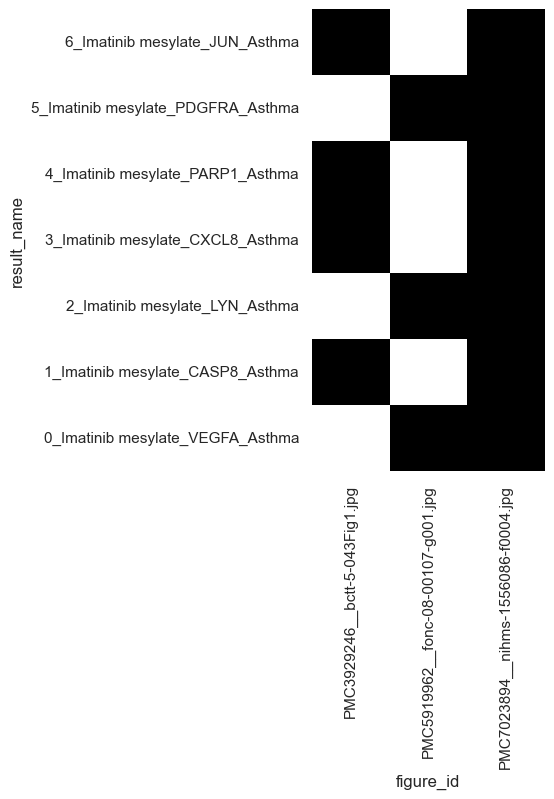

In [13]:
#as heatmap, sorting rows by original TRAPI result order
sorted_result_bool=trapi_results_df['result_name'].isin(df.index)
sorted_result_names=trapi_results_df.loc[sorted_result_bool,'result_name']
sorted_result_index=pd.Index(sorted_result_names)
df=df.reindex(sorted_result_index[::-1])
plt_w = len(pathway_figure_df.index)
plt_h = min(rep_trapi_result_count,plt_w*2)
plt.figure(figsize = (plt_w,plt_h))
sns.set()
sns.heatmap(df, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
if(plt_h ==rep_trapi_result_count):
    print('Pathway figures by TRAPI results, sorting rows by result order')
else:
    print('Pathway figures by TRAPI results, sorting rows by result order  (not all',rep_trapi_result_count,'row names are shown)')
plt.show()

### Matrix of result CURIEs by pathway figures

A binary heatmap of CURIES grouped by pathway figures, sorted by significance (i.e., iteration order).

In [14]:
pathway_figure_df_tall_2 = pathway_figure_df[["figure_id","figure_curies_in_trapi_results"]].explode("figure_curies_in_trapi_results")
rep_curie_count = len(pathway_figure_df_tall_2['figure_curies_in_trapi_results'].unique())
pathway_figure_df_tall_2 = pathway_figure_df_tall_2.rename(columns={"figure_curies_in_trapi_results": "curies"})
pathway_figure_df_tall_2
pathway_figure_df_tall_2["value"]=1
df2=pd.pivot_table(pathway_figure_df_tall_2, values="value", index=["curies"], columns="figure_id", fill_value=0)
df2=df2[pathway_figure_df['figure_id']]
df2=df2.sort_values(by=list(df.columns))
#display(df2)
print('Total number of CURIEs represented by pathways:', rep_curie_count, 'out of', len(total_result_curies_possible ))

Total number of CURIEs represented by pathways: 8 out of 8


Pathway figures by CURIEs (not all 8 row names are shown)


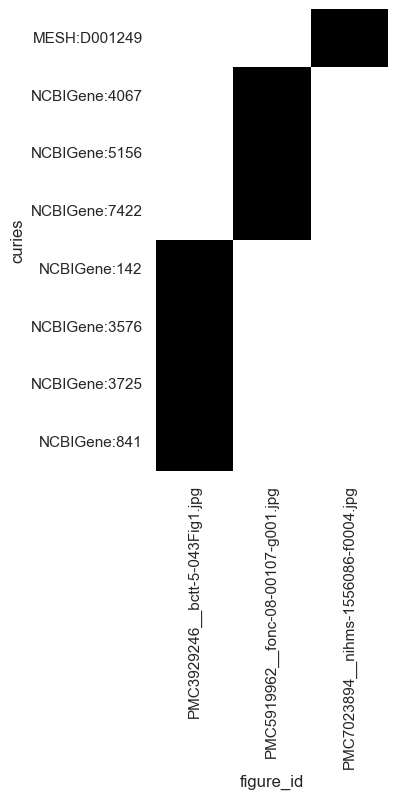

In [15]:
#as heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt_w = len(pathway_figure_df.index)
plt_h = min(rep_curie_count,plt_w*2)
plt.figure(figsize = (plt_w,plt_h))
sns.set()
sns.heatmap(df2, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
if(plt_h ==rep_curie_count):
    print('Pathway figures by CURIEs')
else:
    print('Pathway figures by CURIEs (not all',rep_curie_count,'row names are shown)')
plt.show()